In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import statsmodels.api as sm

In [39]:
import sys
!{sys.executable} -m pip install --upgrade statsmodels --user


In [2]:
df=pd.read_excel('Traffic.xlsx')
df['Start Time'] = pd.to_datetime(df['Start Time'])
df.set_index('Start Time',drop=False,inplace=True)
df=df.drop('Start Time',axis=1)

In [4]:
df.columns

Index(['Cell', 'L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None)',
       'L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None)',
       'L.Traffic.UL.SCH.QPSK.TB (None)',
       'L.Traffic.UL.SCH.QPSK.TB.bits (bit)',
       'L.Traffic.UL.SCH.QPSK.TB.Retrans (None)',
       'L.Traffic.UL.SCH.QPSK.TB.Retrans.bits (bit)',
       'L.Traffic.DL.PktDelay.Num.QCI.9 (packet)',
       'L.Traffic.DL.PktDelay.Time.QCI.9 (ms)',
       'L.Traffic.DL.PktUuLoss.Loss.QCI.9 (packet)',
       'L.Traffic.DL.PktUuLoss.Tot.QCI.9 (packet)',
       'L.Traffic.UL.PktLoss.Loss.QCI.9 (packet)',
       'L.Traffic.UL.PktLoss.Tot.QCI.9 (packet)', 'DL RBLER (%)',
       'L.PDCP.DL.RoHC.HdrCompRatio (%)', 'L.PDCP.DL.RoHC.PktCompRatio (%)',
       'L.PDCP.Tx.Disc.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.Tx.TotRev.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.UL.RoHC.FailDecompRatio (%)', 'L.Traffic.CEU.Avg (None)',
       'L.Traffic.User.ULData.Avg (None)', 'L.Traffic.User.DLData.Avg (None)',
       'L.Traffic.User.Max (None)', 'L.Traffic.Use

In [32]:
df.isna().sum()

Start Time                                      0
Cell                                            0
L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None)        0
L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None)        0
L.Traffic.UL.SCH.QPSK.TB (None)                 0
                                               ..
L.Traffic.UL.SCH.64QAM.ErrTB.Rbler (None)       0
L.Traffic.UL.SCH.64QAM.TB (None)                0
L.Traffic.UL.SCH.64QAM.TB.bits (bit)            0
L.Traffic.UL.SCH.64QAM.TB.Retrans (None)        0
L.Traffic.UL.SCH.64QAM.TB.Retrans.bits (bit)    0
Length: 82, dtype: int64

In [3]:
mean_users=df[['Cell','L.Traffic.User.Avg (None)']].groupby('Cell').mean().reset_index()
mean_users.sort_values('L.Traffic.User.Avg (None)', ascending=False)

,Cell,L.Traffic.User.Avg (None)
72,"Local cell identity=0, Cell Name=eNB_3410-0",117.693921
261,"Local cell identity=2, Cell Name=eNB_3167-2",116.084293
307,"Local cell identity=2, Cell Name=eNB_3525-2",115.423359
3,"Local cell identity=0, Cell Name=eNB_2151-0",112.719250
294,"Local cell identity=2, Cell Name=eNB_3401-2",109.757517
...,...,...
304,"Local cell identity=2, Cell Name=eNB_3518-2",16.712978
238,"Local cell identity=2, Cell Name=eNB_2282_2",15.892523
112,"Local cell identity=1, Cell Name=eNB_2172-1",15.233362
49,"Local cell identity=0, Cell Name=eNB_3186-0",13.597281


In [4]:
df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_3525-2']

df_filter=df_filter.drop('Cell',axis=1)

df_filter.index.freq='15T'
df_filter.index

DatetimeIndex(['2013-08-28 00:00:00', '2013-08-28 00:15:00',
               '2013-08-28 00:30:00', '2013-08-28 00:45:00',
               '2013-08-28 01:00:00', '2013-08-28 01:15:00',
               '2013-08-28 01:30:00', '2013-08-28 01:45:00',
               '2013-08-28 02:00:00', '2013-08-28 02:15:00',
               ...
               '2013-09-04 21:30:00', '2013-09-04 21:45:00',
               '2013-09-04 22:00:00', '2013-09-04 22:15:00',
               '2013-09-04 22:30:00', '2013-09-04 22:45:00',
               '2013-09-04 23:00:00', '2013-09-04 23:15:00',
               '2013-09-04 23:30:00', '2013-09-04 23:45:00'],
              dtype='datetime64[ns]', name='Start Time', length=768, freq='15T')

In [7]:
#list(df_filter.dtypes)

obj_cols = []
for col in df_filter.columns:
    if df_filter[col].dtypes == 'object':
        obj_cols.append(col)
        
obj_cols

[]

In [22]:
list(df_filter.dtypes)

[dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 d

In [6]:
df_filter['DL RBLER (%)']=df_filter['DL RBLER (%)'].astype(float)
#df_filter['DL RBLER (%)'].unique()

In [8]:

df_filter['DL user tput']=df_filter['L.Thrp.bits.DL.QCI.9 (bit)']/(df_filter['L.Thrp.Time.DL.QCI.9 (ms)']*1000)

df_filter['DL cell tput']=df_filter['L.Thrp.bits.DL (bit)']/(df_filter['L.Thrp.Time.Cell.DL (s)']*1000000)

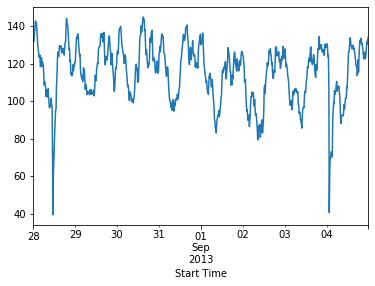

In [9]:
df_filter['L.Traffic.User.Avg (None)'].plot()

#df_filter['DL user tput'].plot()

#sns.distplot(np.log(df_filter['DL user tput']))
#np.log(df_filter['DL user tput']).plot()

-0.728303221924005

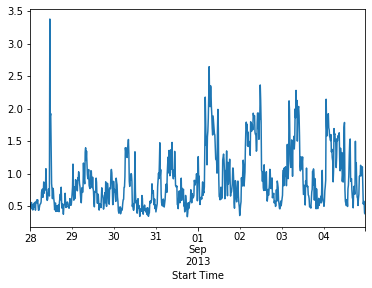

In [10]:
df_filter['DL user tput'].plot()

np.corrcoef(df_filter['DL user tput'],df_filter['L.Traffic.User.Avg (None)'])[1][0]

In [11]:
#sns.pairplot(df_filter)


corrMatrix = df_filter.corr()
#plt.matshow(corrMatrix)
#print (corrMatrix)

In [23]:
drop_columns=list(corrMatrix['DL user tput'][abs(corrMatrix['DL user tput'])<0.65].index)
drop_columns

['L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None)',
 'L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None)',
 'L.Traffic.UL.SCH.QPSK.TB (None)',
 'L.Traffic.UL.SCH.QPSK.TB.bits (bit)',
 'L.Traffic.UL.SCH.QPSK.TB.Retrans (None)',
 'L.Traffic.UL.SCH.QPSK.TB.Retrans.bits (bit)',
 'L.Traffic.DL.PktDelay.Num.QCI.9 (packet)',
 'L.Traffic.DL.PktDelay.Time.QCI.9 (ms)',
 'L.Traffic.DL.PktUuLoss.Loss.QCI.9 (packet)',
 'L.Traffic.DL.PktUuLoss.Tot.QCI.9 (packet)',
 'L.Traffic.UL.PktLoss.Loss.QCI.9 (packet)',
 'DL RBLER (%)',
 'L.Thrp.bits.DL (bit)',
 'L.Thrp.bits.DL.Max (bit)',
 'L.Thrp.bits.DL.QCI.9 (bit)',
 'L.Thrp.bits.DL.QCI.9.Max (bit)',
 'L.Thrp.bits.DL.SRB (bit)',
 'L.Thrp.bits.UL (bit)',
 'L.Thrp.bits.UL.Max (bit)',
 'L.Thrp.bits.UL.QCI.9 (bit)',
 'L.Thrp.bits.UL.SRB (bit)',
 'L.Thrp.bits.UL.QCI.9.Max (bit)',
 'L.Thrp.Time.Cell.DL (s)',
 'L.Thrp.Time.Cell.UL (s)',
 'L.Thrp.Time.UL (ms)',
 'L.Thrp.Time.UL.QCI.9 (ms)',
 'L.UECNTX.AbnormRel (times)',
 'L.UECNTX.NormRel (times)',
 'L.Traffic.BCH.TB.bits (bit)',


In [24]:
df_filter=df_filter.drop(drop_columns,axis=1)

In [25]:
df_filter.columns

Index(['L.Traffic.UL.PktLoss.Tot.QCI.9 (packet)',
       'L.PDCP.DL.RoHC.HdrCompRatio (%)', 'L.PDCP.DL.RoHC.PktCompRatio (%)',
       'L.PDCP.Tx.Disc.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.Tx.TotRev.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.UL.RoHC.FailDecompRatio (%)', 'L.Traffic.CEU.Avg (None)',
       'L.Traffic.User.ULData.Avg (None)', 'L.Traffic.User.DLData.Avg (None)',
       'L.Traffic.User.Max (None)', 'L.Traffic.User.DLData.Max (None)',
       'L.Traffic.User.Avg (None)', 'L.Traffic.CEU.Max (None)',
       'L.Traffic.User.ULData.Max (None)', 'L.E-RAB.SessionTime.QCI9 (s)',
       'L.E-RAB.SessionTime.UE (s)', 'L.Thrp.Time.DL (ms)',
       'L.Thrp.Time.DL.QCI.9 (ms)', 'L.Traffic.DRB (None)',
       'L.Traffic.DRB.QCI.9 (None)',
       'L.Traffic.UL.SCH.64QAM.ErrTB.Ibler (None)',
       'L.Traffic.UL.SCH.64QAM.ErrTB.Rbler (None)',
       'L.Traffic.UL.SCH.64QAM.TB (None)',
       'L.Traffic.UL.SCH.64QAM.TB.bits (bit)',
       'L.Traffic.UL.SCH.64QAM.TB.Retrans (None)',
       'L.

In [50]:
alpha=0.3
ses=SimpleExpSmoothing(df_filter['DL user tput'],initialization_method='legacy-heuristic')

In [52]:
res=ses.fit(smoothing_level=alpha,optimized=False)

In [53]:
df_filter['SES']=res.predict(start=df_filter.index[0],end=df_filter.index[-1])

C:\Users\Ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [54]:
df_filter['SES']

Start Time
2013-08-28 00:00:00    0.494179
2013-08-28 00:15:00    0.494179
2013-08-28 00:30:00    0.502145
2013-08-28 00:45:00    0.503570
2013-08-28 01:00:00    0.520284
                         ...   
2013-09-04 22:45:00    0.953573
2013-09-04 23:00:00    0.828630
2013-09-04 23:15:00    0.752689
2013-09-04 23:30:00    0.699972
2013-09-04 23:45:00    0.608949
Freq: 15T, Name: SES, Length: 768, dtype: float64

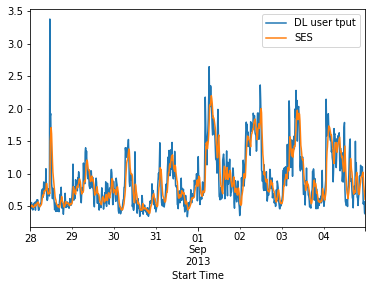

In [56]:
df_filter[['DL user tput','SES']].plot()

In [201]:
Ntest=96
train=df_filter.iloc[:-Ntest]
test=df_filter.iloc[-Ntest:]

In [60]:
ses=SimpleExpSmoothing(train['DL user tput'],initialization_method='legacy-heuristic')
res=ses.fit()

In [202]:
train_idx=df_filter.index <= train.index[-1]
test_idx=df_filter.index > train.index[-1]

C:\Users\Ahmad\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Ahmad\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


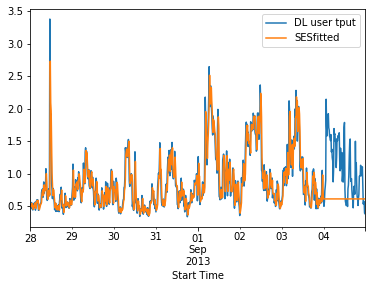

In [63]:
df_filter.loc[train_idx,'SESfitted']=res.fittedvalues
df_filter.loc[test_idx,'SESfitted']=res.forecast(Ntest)
df_filter[['DL user tput','SESfitted']].plot()

In [68]:
holt=Holt(train['DL user tput'],initialization_method='legacy-heuristic')
res_h=holt.fit()

In [87]:
df_filter.loc[train_idx,'Holt']=res_h.fittedvalues
df_filter.loc[test_idx,'Holt']=res_h.forecast(Ntest)

C:\Users\Ahmad\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


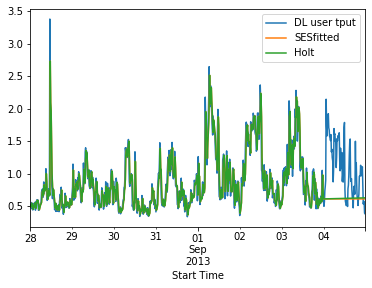

In [88]:
df_filter[['DL user tput','SESfitted','Holt']].plot()

In [225]:
HW=ExponentialSmoothing((train['DL user tput']),initialization_method='estimated',damped_trend=False,trend='add',seasonal='mul',use_boxcox=False,seasonal_periods=96)
res_hw=HW.fit()

C:\Users\Ahmad\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


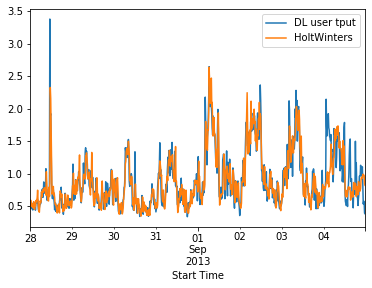

In [226]:
df_filter.loc[train_idx,'HoltWinters']=(res_hw.fittedvalues)
df_filter.loc[test_idx,'HoltWinters']=(res_hw.forecast(Ntest))
#df_filter['HoltWinters']=np.sqrt(df_filter['HoltWinters'])
df_filter[['DL user tput','HoltWinters']].plot()

In [227]:
test['HW']=(res_hw.forecast(Ntest))

C:\Users\Ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.20484488947215385

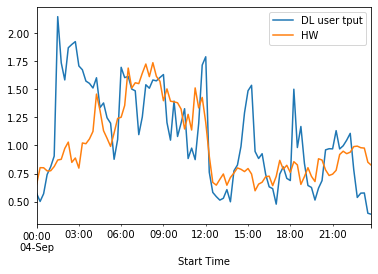

In [228]:
test[['DL user tput','HW']].plot()
r2_score(test['DL user tput'],test['HW'])

In [103]:
df_filter['DL user tput'].iloc[-Ntest:].min()

0.38699048076380715

In [171]:
mean_squared_error(test['DL user tput'],test['HW'])

0.16085181356443537

In [219]:
h=96
steps=10
Ntest=len(df_filter)-96-steps+1

In [220]:
def walkforward(trend_type,seasonal_type,damped_trend,init_method,use_boxcox,debug=False):
    errors=[]
    seen_last=False
    steps_completed=0
    
    for end_of_train in range(Ntest, len(df)-h+1):
        train=df_filter.iloc[:end_of_train]
        test=df_filter.iloc[end_of_train:end_of_train+h]
        
        if test.index[-1]==df_filter.index[-1]:
            seen_last=True
            
        steps_completed +=1
        
        hw=ExponentialSmoothing(
        train['DL user tput'],
        initialization_method=init_method,
        trend=trend_type,
        damped_trend=damped_trend,
        seasonal=seasonal_type,
        seasonal_periods=96,
        use_boxcox=use_boxcox)
        res_hw=hw.fit()
        
        fcast=res_hw.forecast(h)
        error=mean_squared_error(test['DL user tput'],fcast)
        errors.append(error)
        
        if debug:
            print("seen last:",seen_last)
            print("steps completed:",steps_completed)
            
        return np.mean(errors)
    
    

In [221]:
trend_type_list=['add']
seasonal_type_list=['add','mul']
damped_trend_list=[True,False]
init_method_list=['estimated','heuristic','legacy-heuristic']
use_boxcox_list=[True,False,0]

tupe_of_option_lists=(
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list,
    use_boxcox_list   

)

In [222]:
best_score=float('inf')
best_options=None
for x in itertools.product(*tupe_of_option_lists):
    score=walkforward(*x)
    
    if score < best_score:
        print("Best score so far:",score)
        best_score=score
        best_options=x

Best score so far: 0.33326894632827425
Best score so far: 0.23288932812652585


C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\

Best score so far: 0.17959419224947795


C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [224]:
print("best score:",best_score)

trend_type,seasonal_type,damped_trend,init_method,use_boxcox=best_options
print("trend_type",trend_type)
print("seasonal_type",seasonal_type)
print("damped_trend",damped_trend)
print("init_method",init_method)
print("use_boxcox",use_boxcox)

best score: 0.17959419224947795
trend_type add
seasonal_type mul
damped_trend False
init_method estimated
use_boxcox False
